<a href="https://colab.research.google.com/github/attmhd/DC-CNN-EOG/blob/main/Dual_Channel_EOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from scipy import signal

def generate_realistic_eog_data(n_samples=1000, signal_length=256, sampling_rate=256):
    """
    Generate realistic EOG data untuk 4 classes:
    0 = kanan, 1 = kiri, 2 = atas, 3 = bawah
    """

    # Initialize arrays
    horizontal_data = np.zeros((n_samples, signal_length, 1))
    vertical_data = np.zeros((n_samples, signal_length, 1))
    labels = np.random.randint(0, 4, size=n_samples)

    # Time vector
    t = np.linspace(0, 1, signal_length)  # 1 second duration

    for i in range(n_samples):
        label = labels[i]

        # Base noise untuk kedua channel
        base_noise_h = 0.05 * np.random.randn(signal_length)
        base_noise_v = 0.05 * np.random.randn(signal_length)

        # Generate spike patterns berdasarkan label
        if label == 0:  # KANAN
            # Horizontal: spike positif
            spike_h = generate_spike_pattern(t, amplitude=0.8, direction='positive')
            # Vertical: mostly flat dengan sedikit variasi (gerakan tidak sempurna)
            spike_v = 0.1 * np.random.randn(signal_length)  # small variation

        elif label == 1:  # KIRI
            # Horizontal: spike negatif
            spike_h = generate_spike_pattern(t, amplitude=0.8, direction='negative')
            # Vertical: mostly flat
            spike_v = 0.1 * np.random.randn(signal_length)

        elif label == 2:  # ATAS
            # Horizontal: mostly flat
            spike_h = 0.1 * np.random.randn(signal_length)
            # Vertical: spike positif
            spike_v = generate_spike_pattern(t, amplitude=0.7, direction='positive')

        else:  # label == 3, BAWAH
            # Horizontal: mostly flat
            spike_h = 0.1 * np.random.randn(signal_length)
            # Vertical: spike negatif
            spike_v = generate_spike_pattern(t, amplitude=0.7, direction='negative')

        # Combine spike + noise
        horizontal_data[i, :, 0] = spike_h + base_noise_h
        vertical_data[i, :, 0] = spike_v + base_noise_v

    return horizontal_data, vertical_data, labels

def generate_spike_pattern(t, amplitude=0.8, direction='positive'):
    """
    Generate realistic spike pattern (saccade-like)
    """
    # Spike location (random antara 0.3-0.7 detik)
    spike_center = np.random.uniform(0.3, 0.7)
    spike_width = 0.1  # 100ms duration

    # Gaussian-like spike shape
    spike = amplitude * np.exp(-((t - spike_center) / spike_width) ** 2)

    if direction == 'negative':
        spike = -spike

    # Add some realistic overshoot/undershoot
    overshoot_time = spike_center + 0.05
    if overshoot_time < 1.0:
        overshoot_idx = int(overshoot_time * len(t))
        spike[overshoot_idx:overshoot_idx+10] += -0.1 * amplitude * (1 if direction == 'positive' else -1)

    return spike

# ==========================================
# Generate Data
# ==========================================
print("Generating realistic EOG data...")
X_horizontal, X_vertical, y = generate_realistic_eog_data(n_samples=2000)

# Convert labels to categorical
y_categorical = tf.keras.utils.to_categorical(y, 4)

print(f"Data shape:")
print(f"Horizontal: {X_horizontal.shape}")
print(f"Vertical: {X_vertical.shape}")
print(f"Labels: {y.shape}")
print(f"Label distribution: {np.bincount(y)}")


Generating realistic EOG data...
Data shape:
Horizontal: (2000, 256, 1)
Vertical: (2000, 256, 1)
Labels: (2000,)
Label distribution: [506 473 493 528]


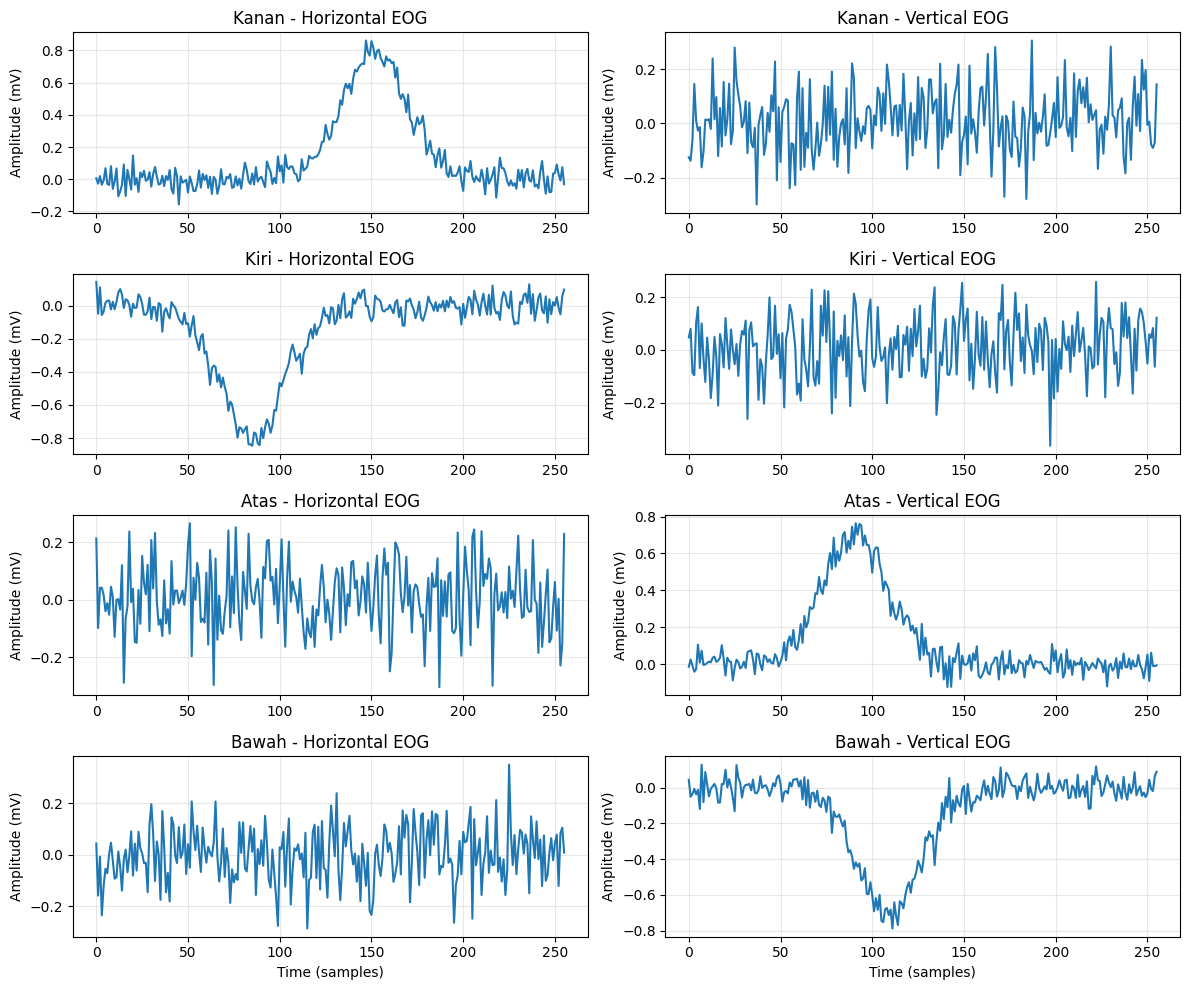

In [3]:
def plot_eog_samples():
    """Plot contoh dari setiap class untuk verifikasi"""

    fig, axes = plt.subplots(4, 2, figsize=(12, 10))
    class_names = ['Kanan', 'Kiri', 'Atas', 'Bawah']

    for class_idx in range(4):
        # Cari sample pertama dari class ini
        sample_idx = np.where(y == class_idx)[0][0]

        # Plot horizontal channel
        axes[class_idx, 0].plot(X_horizontal[sample_idx, :, 0])
        axes[class_idx, 0].set_title(f'{class_names[class_idx]} - Horizontal EOG')
        axes[class_idx, 0].set_ylabel('Amplitude (mV)')
        axes[class_idx, 0].grid(True, alpha=0.3)

        # Plot vertical channel
        axes[class_idx, 1].plot(X_vertical[sample_idx, :, 0])
        axes[class_idx, 1].set_title(f'{class_names[class_idx]} - Vertical EOG')
        axes[class_idx, 1].set_ylabel('Amplitude (mV)')
        axes[class_idx, 1].grid(True, alpha=0.3)

        if class_idx == 3:  # last row
            axes[class_idx, 0].set_xlabel('Time (samples)')
            axes[class_idx, 1].set_xlabel('Time (samples)')

    plt.tight_layout()
    plt.show()

# Visualize samples
plot_eog_samples()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ==========================================
# Data Splitting
# ==========================================
print("Splitting data...")

# Split data (80% train, 20% test)
X_h_train, X_h_test, X_v_train, X_v_test, y_train, y_test = train_test_split(
    X_horizontal, X_vertical, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y  # pastikan proporsi class seimbang
)

print(f"Training data - Horizontal: {X_h_train.shape}, Vertical: {X_v_train.shape}")
print(f"Test data - Horizontal: {X_h_test.shape}, Vertical: {X_v_test.shape}")
print(f"Training labels: {y_train.shape}")


Splitting data...
Training data - Horizontal: (1600, 256, 1), Vertical: (1600, 256, 1)
Test data - Horizontal: (400, 256, 1), Vertical: (400, 256, 1)
Training labels: (1600, 4)


In [7]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# ==========================================
# Model Definition
# ==========================================

# Input layers untuk 2 channel
input_h = Input(shape=(256, 1), name='horizontal_input')
input_v = Input(shape=(256, 1), name='vertical_input')

# Branch untuk Horizontal EOG
x1 = Conv1D(32, 3, activation='relu')(input_h)
x1 = MaxPooling1D(2)(x1)
x1 = Conv1D(64, 3, activation='relu')(x1)
x1 = MaxPooling1D(2)(x1)
x1 = Flatten()(x1)

# Branch untuk Vertical EOG
x2 = Conv1D(32, 3, activation='relu')(input_v)
x2 = MaxPooling1D(2)(x2)
x2 = Conv1D(64, 3, activation='relu')(x2)
x2 = MaxPooling1D(2)(x2)
x2 = Flatten()(x2)

# Gabungkan kedua branch
combined = concatenate([x1, x2])

# Fully connected layers
dense1 = Dense(100, activation='relu')(combined)
output = Dense(4, activation='softmax')(dense1)  # 4 classes

# Buat model
model = Model(inputs=[input_h, input_v], outputs=output)

# Tampilkan summary model
model.summary()

# ==========================================
# Model Compilation
# ==========================================


print("Compiling model...")

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback untuk monitoring training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    )
]

# ==========================================
# Training Process
# ==========================================
print("Starting training...")

history = model.fit(
    [X_h_train, X_v_train],  # dual input
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,  # 20% dari training untuk validation
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ horizontal_input    │ (None, 256, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vertical_input      │ (None, 256, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 254, 32)   │        128 │ horizontal_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 254, 32)   │        128 │ vertical_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 127, 32)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 127, 32)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 64)   │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 125, 64)   │      6,208 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 62, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 62, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3968)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3968)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7936)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │    793,700 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        404 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 806,776 (3.08 MB)

 Trainable params: 806,776 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model...
Starting training...
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9195 - loss: 0.4725 - val_accuracy: 1.0000 - val_loss: 4.4766e-05 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 2.5590e-05 - val_accuracy: 1.0000 - val_loss: 1.3360e-05 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 1.3339e-05 - val_accuracy: 1.0000 - val_loss: 1.1328e-05 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.0000 - loss: 1.0986e-05 - val_accuracy: 1.0000 - val_loss: 1.0120e-05 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - loss: 9.6223e-06 - val_accuracy: 1.0000 - val_loss: 9.2799e-06 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 7.7372e-06 - val_accuracy: 1.0000 - val_loss: 8.6004e-06 - learning_rate: 0.0010
Epoch 7/50

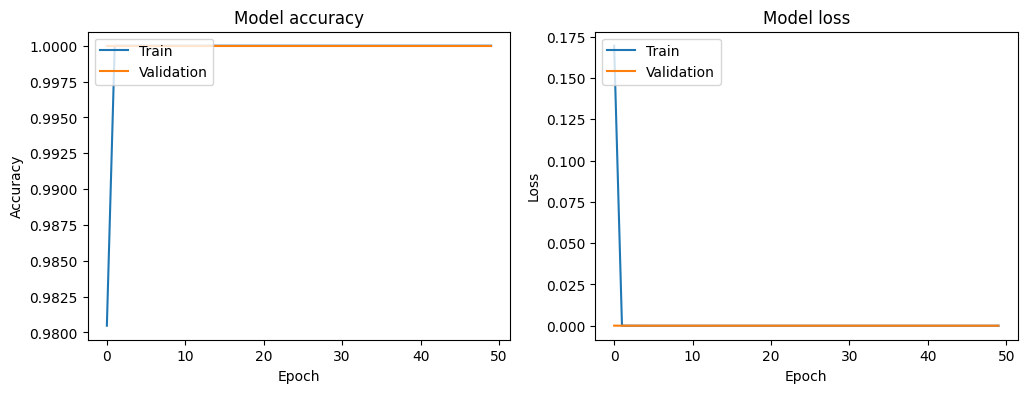

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


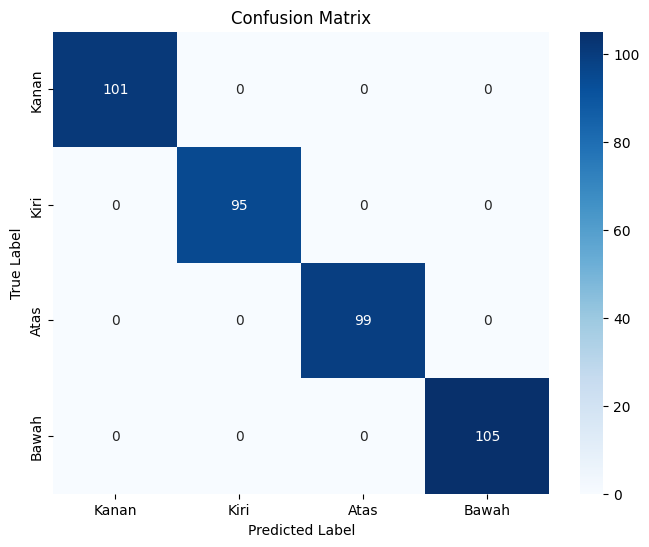


Per-class Accuracy:
Kanan: 1.0000
Kiri: 1.0000
Atas: 1.0000
Bawah: 1.0000


In [9]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Kanan', 'Kiri', 'Atas', 'Bawah']


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Akurasi per class
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-class Accuracy:")
    for i, acc in enumerate(class_accuracy):
        print(f"{class_names[i]}: {acc:.4f}")

# Get model predictions
y_pred_probs = model.predict([X_h_test, X_v_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)

In [13]:
from sklearn.metrics import classification_report

class_names = ['Kanan', 'Kiri', 'Atas', 'Bawah']
# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Kanan       1.00      1.00      1.00       101
        Kiri       1.00      1.00      1.00        95
        Atas       1.00      1.00      1.00        99
       Bawah       1.00      1.00      1.00       105

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


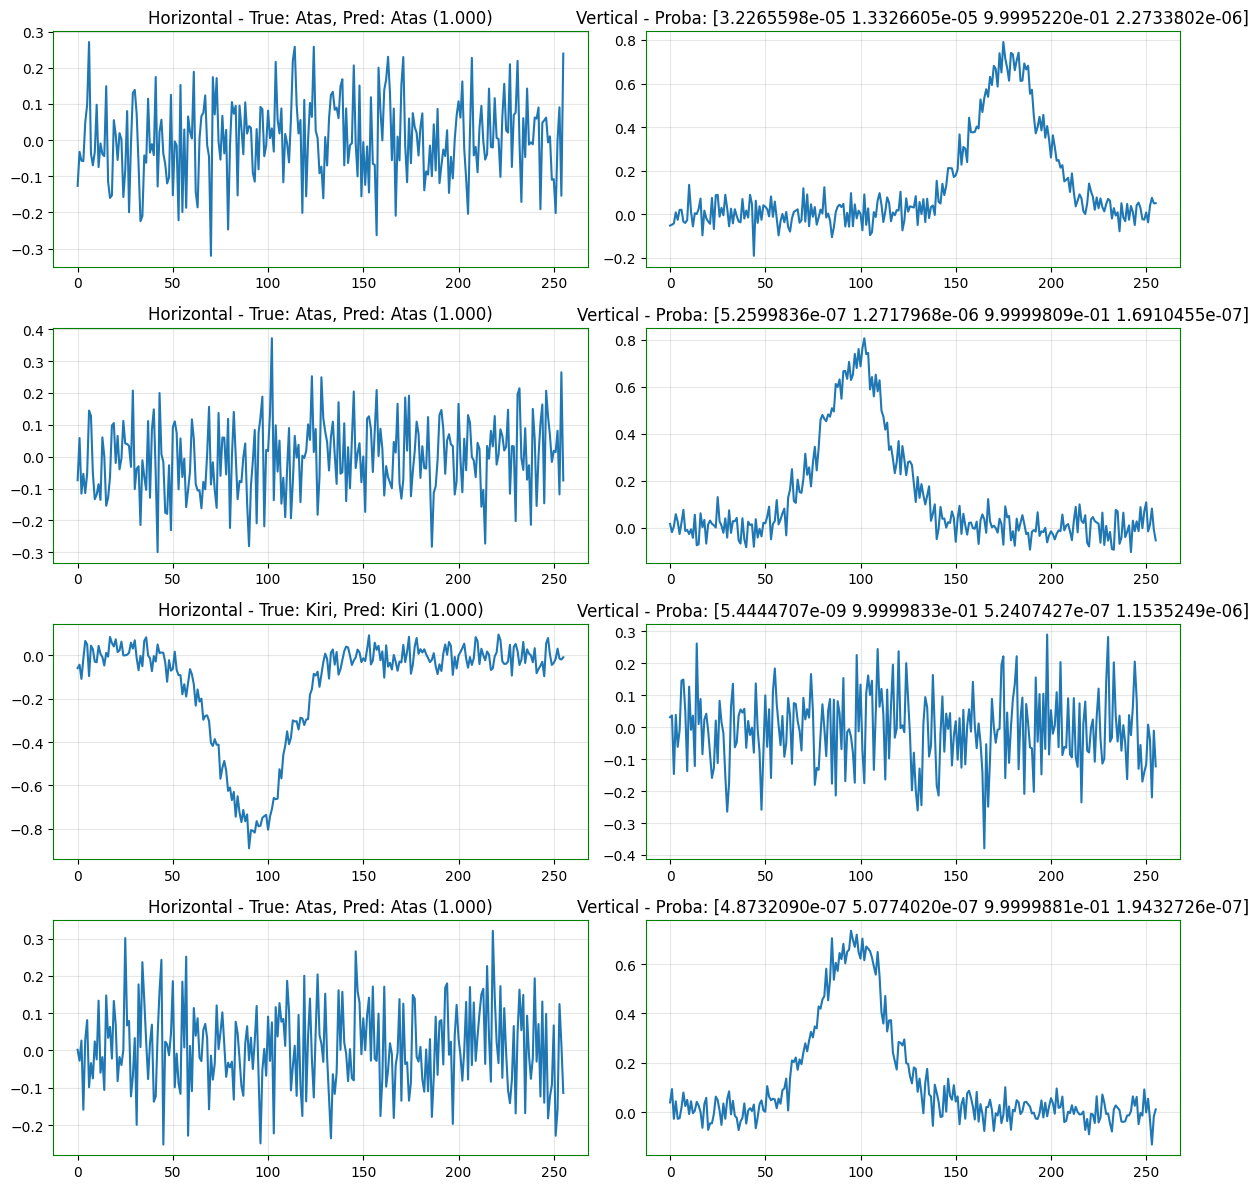

In [11]:
def analyze_predictions(model, X_h_test, X_v_test, y_test, n_samples=4):
    """Analyze beberapa predictions dengan confidence scores"""
    class_names = ['Kanan', 'Kiri', 'Atas', 'Bawah']
    # Ambil random samples
    indices = np.random.choice(len(X_h_test), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 2, figsize=(12, 3*n_samples))

    for i, idx in enumerate(indices):
        # Get prediction
        pred_proba = model.predict([X_h_test[idx:idx+1], X_v_test[idx:idx+1]])[0]
        pred_class = np.argmax(pred_proba)
        true_class = np.argmax(y_test[idx])
        confidence = pred_proba[pred_class]

        # Plot horizontal channel
        axes[i, 0].plot(X_h_test[idx, :, 0])
        axes[i, 0].set_title(f'Horizontal - True: {class_names[true_class]}, '
                           f'Pred: {class_names[pred_class]} ({confidence:.3f})')
        axes[i, 0].grid(True, alpha=0.3)

        # Plot vertical channel
        axes[i, 1].plot(X_v_test[idx, :, 0])
        axes[i, 1].set_title(f'Vertical - Proba: {pred_proba}')
        axes[i, 1].grid(True, alpha=0.3)

        # Color coding: green jika benar, red jika salah
        color = 'green' if pred_class == true_class else 'red'
        for ax in axes[i]:
            ax.spines['top'].set_color(color)
            ax.spines['right'].set_color(color)
            ax.spines['bottom'].set_color(color)
            ax.spines['left'].set_color(color)

    plt.tight_layout()
    plt.show()

# Analyze predictions
analyze_predictions(model, X_h_test, X_v_test, y_test)